<a href="https://colab.research.google.com/github/Mahekjain2706/Semi-Asynchronous-Centralized-Learning/blob/main/Sem_Asynchronous_Centralized_FL_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# ***Load CIFAR-10 dataset***

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

170498071/170498071 [==============================] - 3s 0us/step


# ***One-hot encode labels***

In [4]:
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# ***Split training data into clients***

In [5]:
client_data = np.array_split(X_train, 5)
client_labels = np.array_split(y_train_encoded, 5)

# ***Define activation functions and loss function***

In [6]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels):
    return -np.mean(np.sum(labels * np.log(predictions + 1e-9), axis=1))

# ***Define SimpleNN class***

In [7]:
class SimpleNN:
    def __init__(self, input_shape, num_classes):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=input_shape),
            tf.keras.layers.Dense(128, activation='sigmoid'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        self.model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    def forward(self, X):
        return self.model.predict(X)

    def backward(self, X, y, epochs, batch_size):
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

# ***Initialize client and server models***

In [8]:
client_models = [SimpleNN(X_train.shape[1:], 10) for _ in range(5)]
server_model = SimpleNN(X_train.shape[1:], 10)

# ***Hyperparameters***

In [9]:
epochs = 5
rounds = 10
batch_size = 32

# ***Class names for CIFAR-10***

In [10]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# ***Function to display client samples***

In [11]:
def display_client_samples(samples, labels, client_index):
    plt.figure(figsize=(10, 3))
    for i in range(len(samples)):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(samples[i])
        plt.title(f'Label: {class_names[np.argmax(labels[i])]}')
        plt.axis('off')
    plt.suptitle(f'Client {client_index + 1} Samples')
    plt.show()

# ***Semi-asynchronous federated learning***

In [12]:
def semi_async_update(client_models, server_model, client_data, client_labels, epochs, batch_size):
    client_losses = [[] for _ in range(len(client_models))]
    client_accuracies = [[] for _ in range(len(client_models))]

    for round in range(rounds):
        print(f"Round {round+1}/{rounds}")

        client_indices = np.random.permutation(len(client_models))

        for i in client_indices:
            print(f"Client {i + 1} providing information:")
            display_client_samples(client_data[i][:5], client_labels[i][:5], i)  # Display client samples
            client_models[i].backward(client_data[i], client_labels[i], epochs, batch_size)

        server_weights = [layer.get_weights() for layer in server_model.model.layers]
        client_weights = [[layer.get_weights() for layer in model.model.layers] for model in client_models]

        new_weights = []
        for layer_idx in range(len(server_weights)):
            layer_weights = [client_weights[client_idx][layer_idx] for client_idx in range(len(client_weights))]
            mean_weights = [np.mean([w[weight_idx] for w in layer_weights], axis=0) for weight_idx in range(len(layer_weights[0]))]
            new_weights.append(mean_weights)

        for layer_idx, weights in enumerate(new_weights):
            server_model.model.layers[layer_idx].set_weights(weights)

        for i, model in enumerate(client_models):
            client_predictions = model.forward(X_test)
            loss = cross_entropy_loss(client_predictions, y_test_encoded)
            acc = np.mean(np.argmax(client_predictions, axis=1) == np.argmax(y_test_encoded, axis=1))
            client_losses[i].append(loss)
            client_accuracies[i].append(acc)
            print(f"Client {i + 1} - Loss: {loss}, Accuracy: {acc}")

    return client_losses, client_accuracies

# ***Simulate semi-asynchronous federated learning***

Round 1/10
Client 2 providing information:


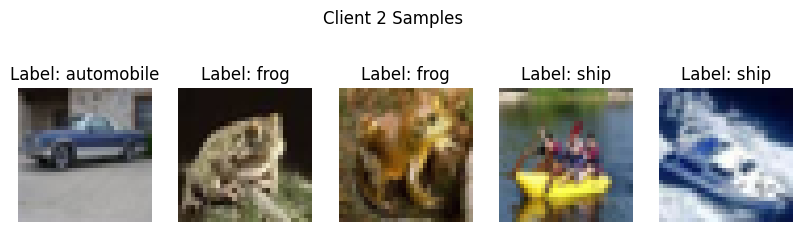

Client 5 providing information:


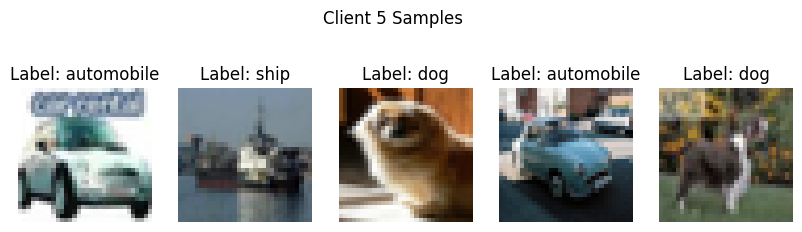

Client 4 providing information:


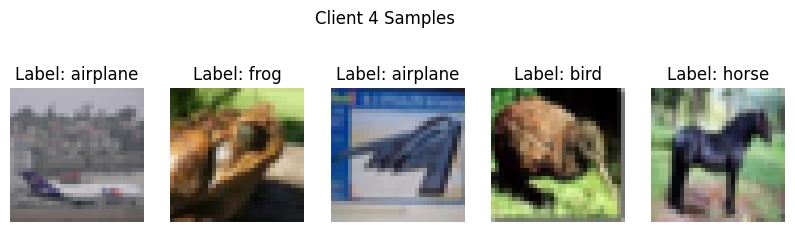

Client 3 providing information:


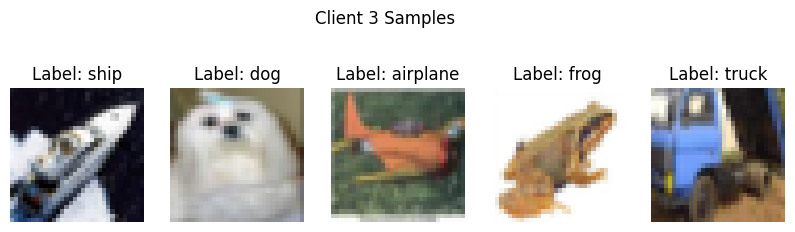

Client 1 providing information:


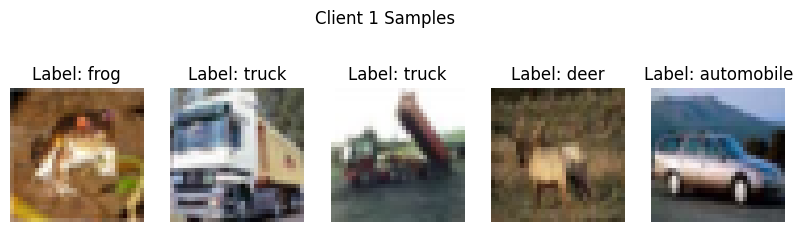

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.921084408918023, Accuracy: 0.3485
313/313 [==============================] - 1s 2ms/step
Client 2 - Loss: 1.9369640320539474, Accuracy: 0.3172
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.9320215249896049, Accuracy: 0.3224
313/313 [==============================] - 1s 4ms/step
Client 4 - Loss: 1.9357258083820343, Accuracy: 0.3165
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.9327279551804066, Accuracy: 0.3348
Round 2/10
Client 5 providing information:


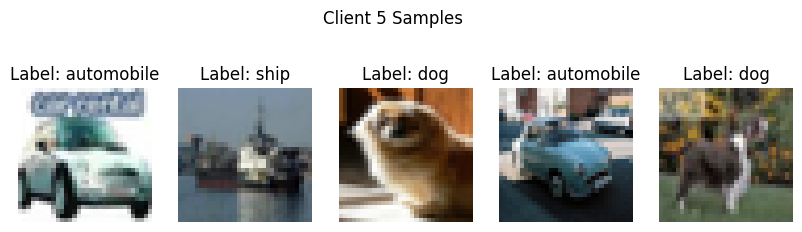

Client 3 providing information:


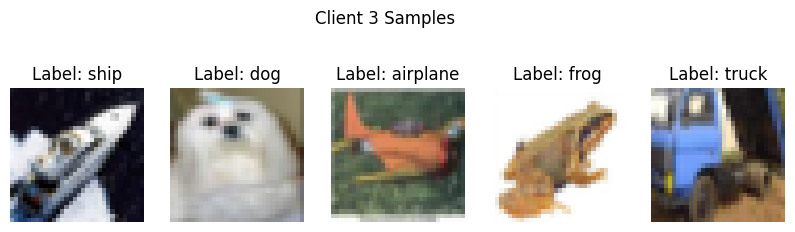

Client 1 providing information:


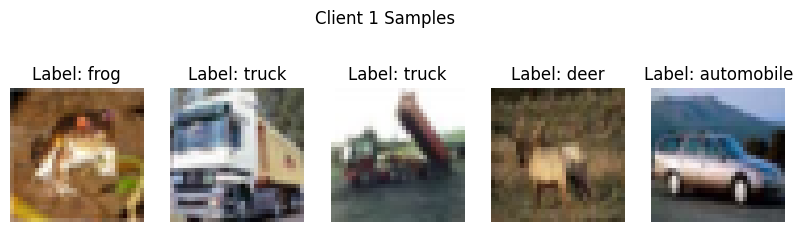

Client 2 providing information:


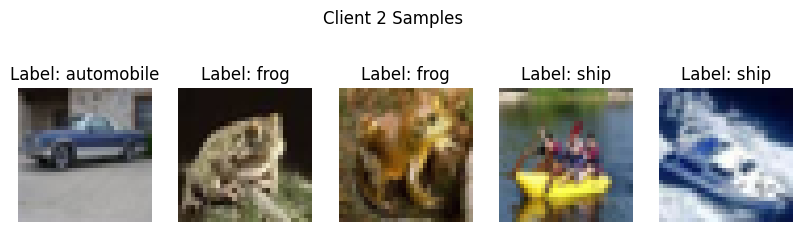

Client 4 providing information:


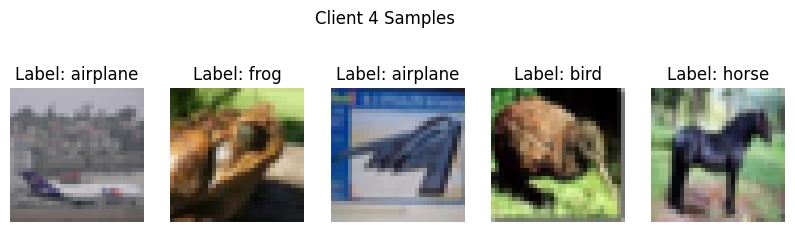

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.8523057221770287, Accuracy: 0.3426
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.8613254375755788, Accuracy: 0.3503
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.8530256260693074, Accuracy: 0.3569
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.858069627277553, Accuracy: 0.3516
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.867153942680359, Accuracy: 0.3368
Round 3/10
Client 5 providing information:


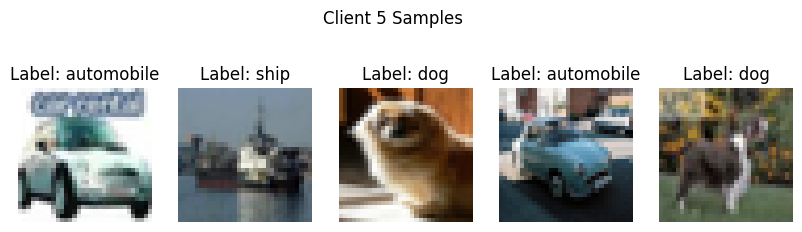

Client 4 providing information:


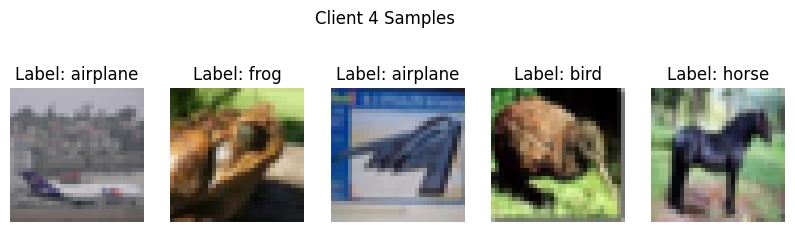

Client 3 providing information:


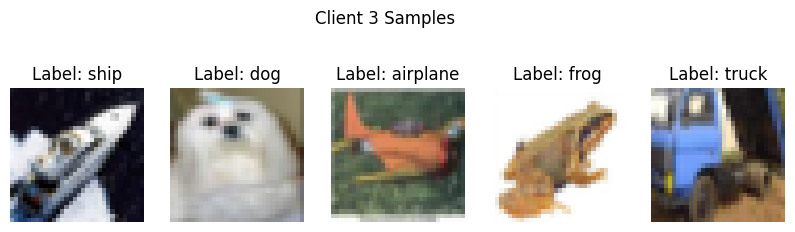

Client 2 providing information:


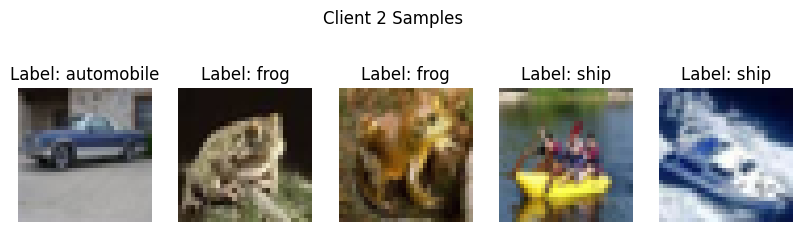

Client 1 providing information:


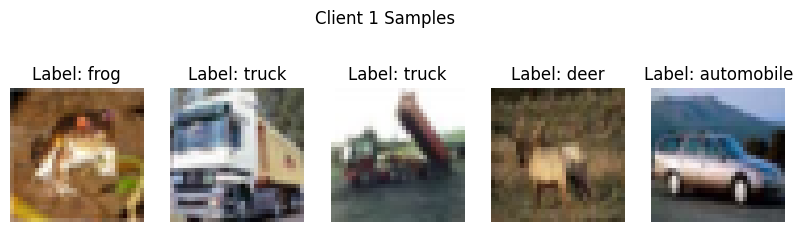

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.812557143817842, Accuracy: 0.3756
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.8204230864435433, Accuracy: 0.3653
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.8154140768289566, Accuracy: 0.3626
313/313 [==============================] - 1s 5ms/step
Client 4 - Loss: 1.8160386009454728, Accuracy: 0.37
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.8133725613802671, Accuracy: 0.3676
Round 4/10
Client 1 providing information:


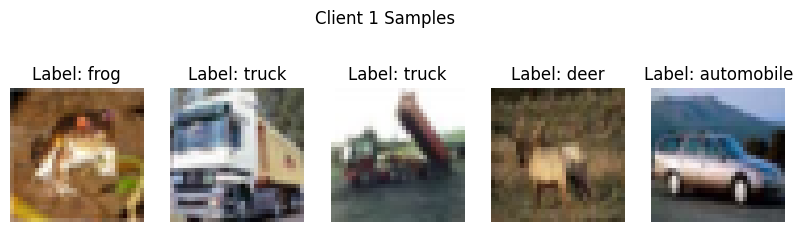

Client 4 providing information:


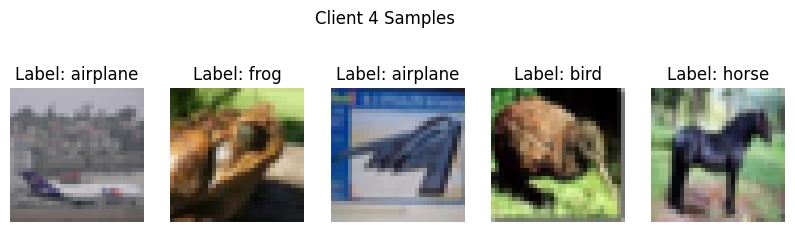

Client 5 providing information:


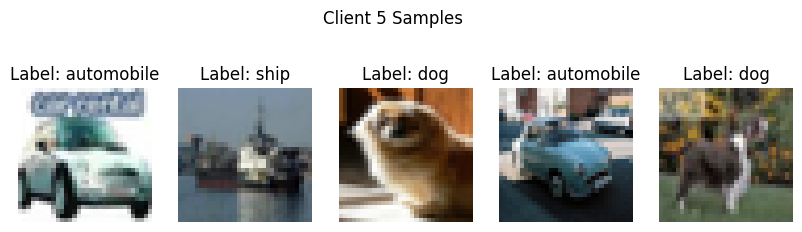

Client 2 providing information:


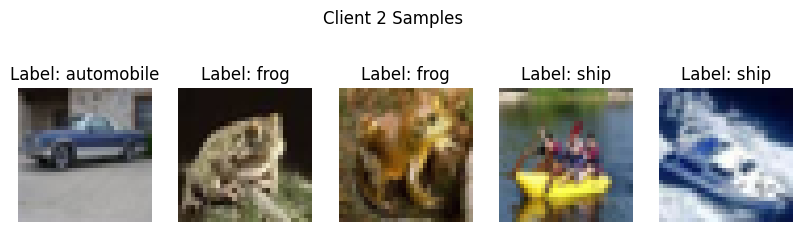

Client 3 providing information:


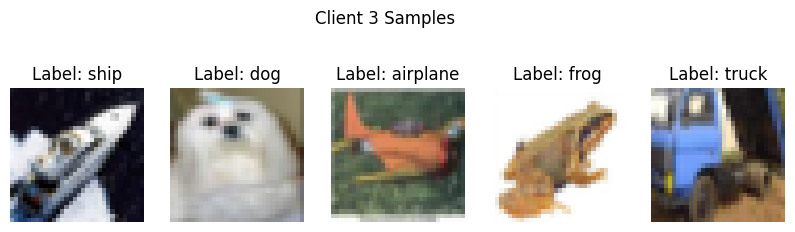

313/313 [==============================] - 1s 4ms/step
Client 1 - Loss: 1.8051903312012554, Accuracy: 0.3654
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7942846063494682, Accuracy: 0.3781
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.7938913448616862, Accuracy: 0.3749
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.8018361352324486, Accuracy: 0.3683
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7915070156171917, Accuracy: 0.3781
Round 5/10
Client 1 providing information:


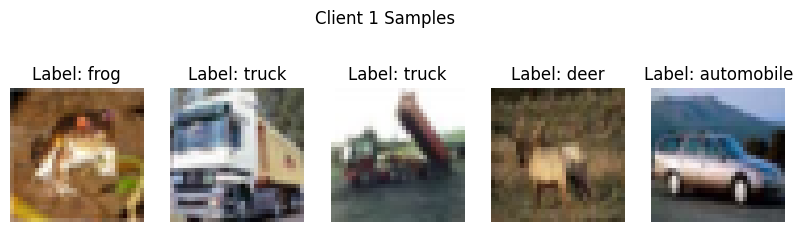

Client 4 providing information:


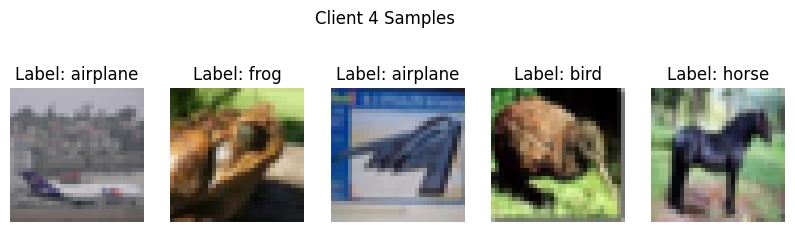

Client 2 providing information:


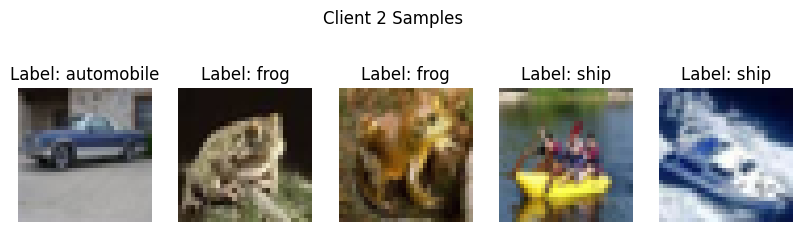

Client 5 providing information:


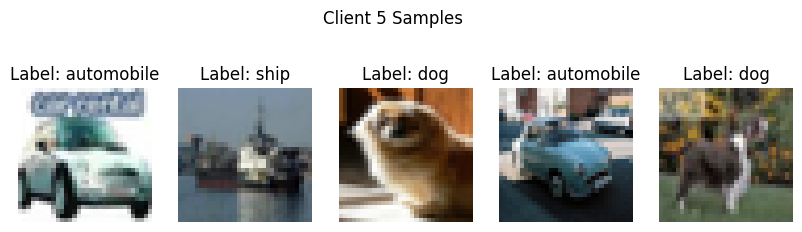

Client 3 providing information:


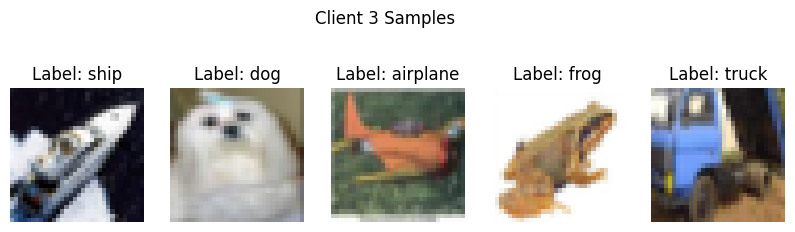

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.765405790401995, Accuracy: 0.3849
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7714983924493193, Accuracy: 0.3876
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.7790712754532694, Accuracy: 0.3762
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.7820875738099218, Accuracy: 0.3816
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7745399919763207, Accuracy: 0.3797
Round 6/10
Client 2 providing information:


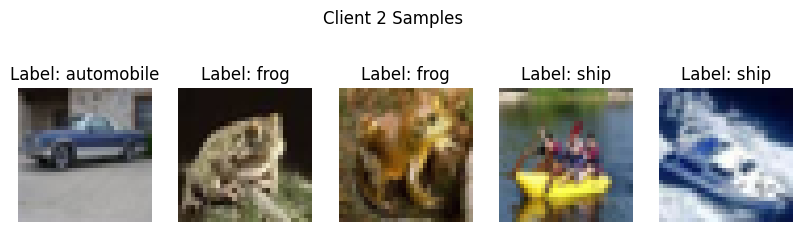

Client 5 providing information:


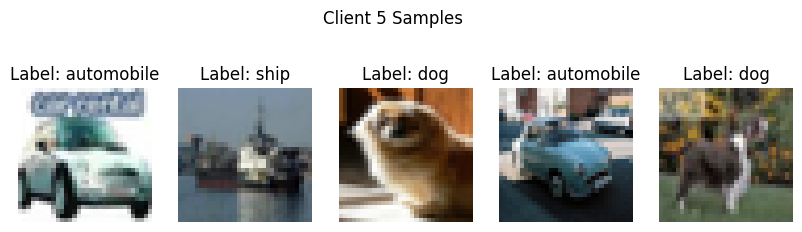

Client 4 providing information:


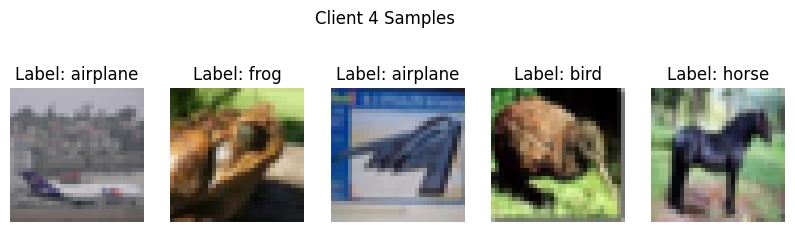

Client 3 providing information:


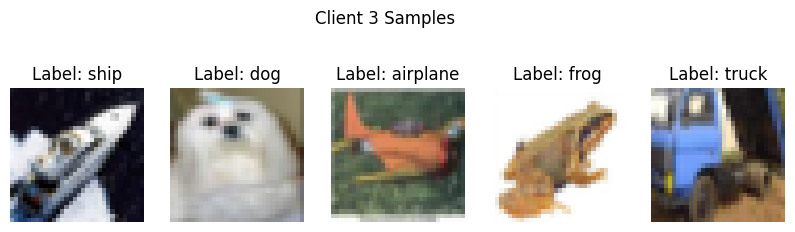

Client 1 providing information:


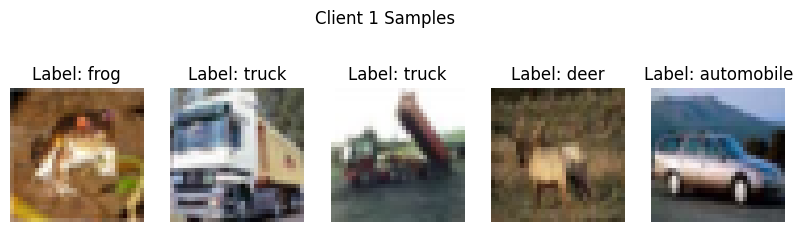

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.7540985077001154, Accuracy: 0.383
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7567772483214736, Accuracy: 0.3909
313/313 [==============================] - 1s 4ms/step
Client 3 - Loss: 1.7540687040060758, Accuracy: 0.3858
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.7604704686641692, Accuracy: 0.3835
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7613232797406613, Accuracy: 0.3838
Round 7/10
Client 5 providing information:


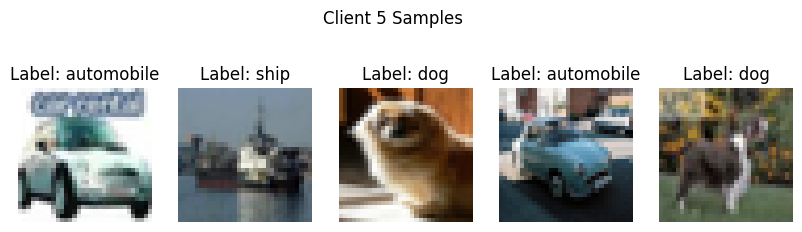

Client 1 providing information:


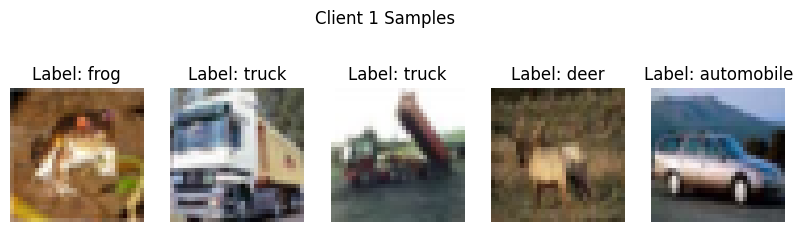

Client 2 providing information:


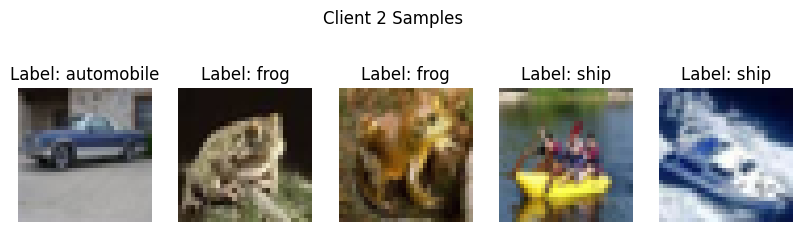

Client 3 providing information:


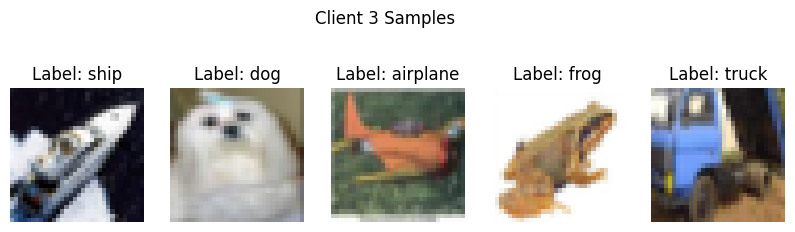

Client 4 providing information:


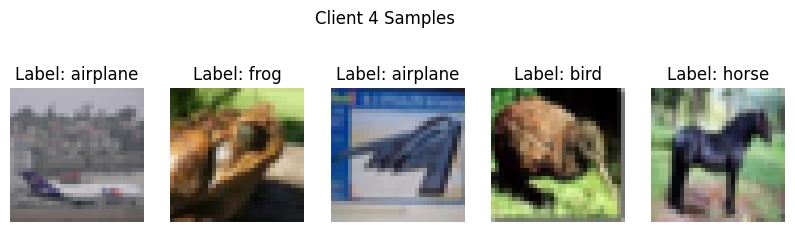

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.746108952152729, Accuracy: 0.3857
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7435172728300095, Accuracy: 0.3942
313/313 [==============================] - 1s 2ms/step
Client 3 - Loss: 1.7424416288156062, Accuracy: 0.3919
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.749104334499687, Accuracy: 0.3883
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7621763919308782, Accuracy: 0.3735
Round 8/10
Client 4 providing information:


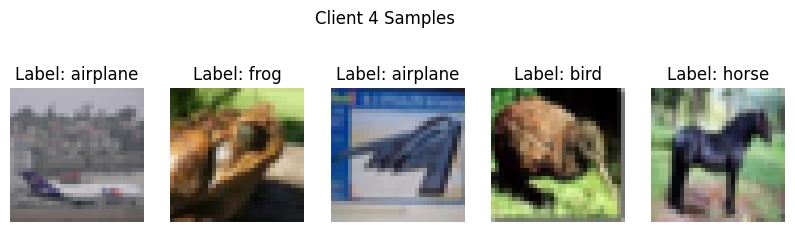

Client 3 providing information:


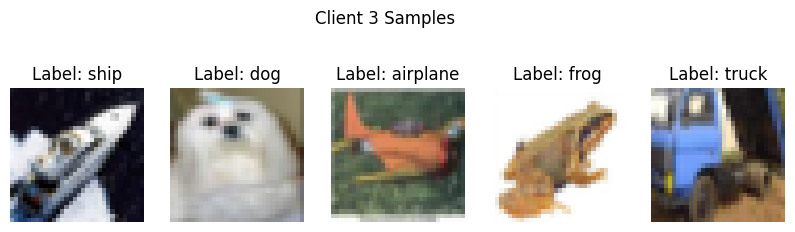

Client 2 providing information:


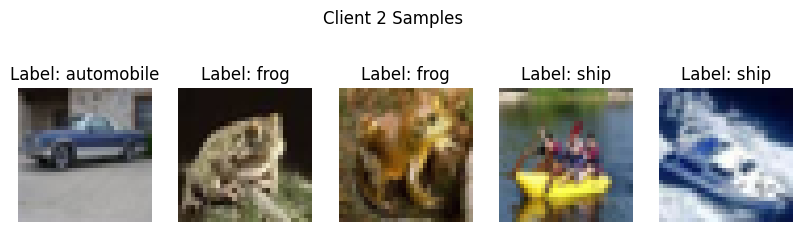

Client 1 providing information:


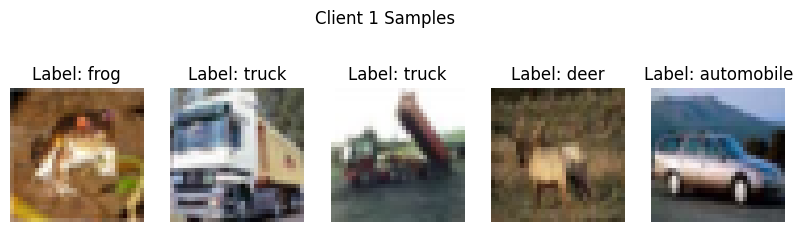

Client 5 providing information:


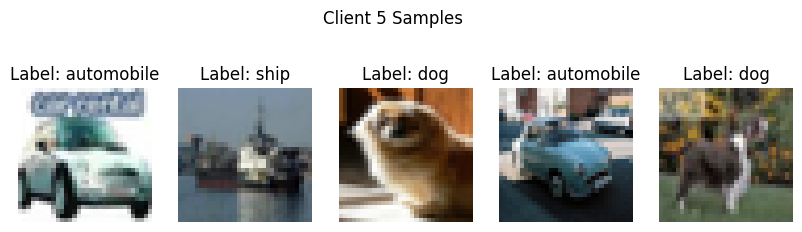

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.7254309276089073, Accuracy: 0.4023
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7197407554175705, Accuracy: 0.3962
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.7274877470262349, Accuracy: 0.3952
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.7374011333230883, Accuracy: 0.3973
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7355213906623423, Accuracy: 0.3882
Round 9/10
Client 2 providing information:


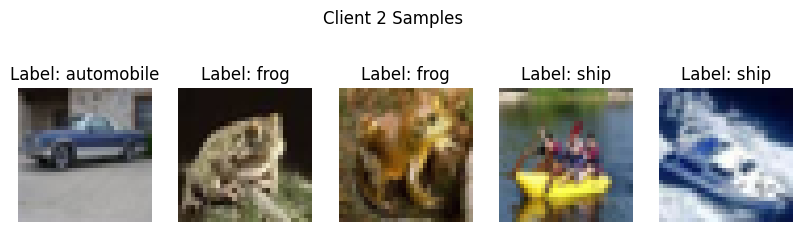

Client 5 providing information:


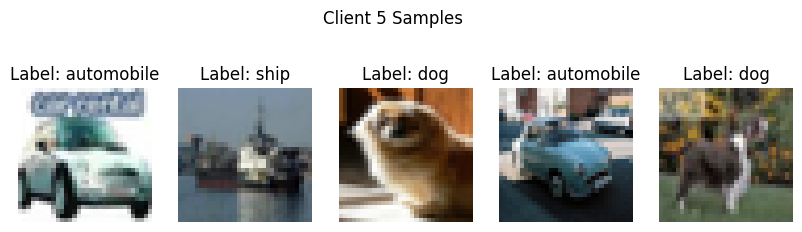

Client 1 providing information:


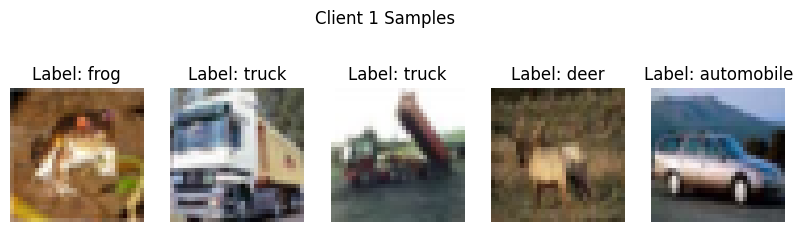

Client 4 providing information:


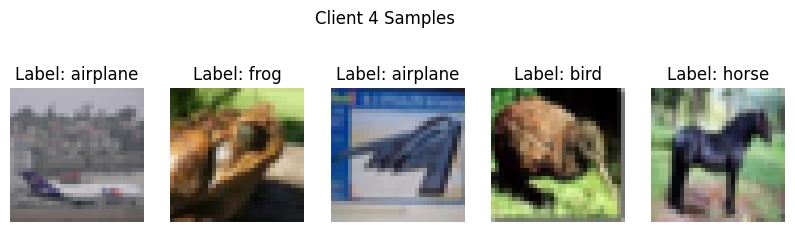

Client 3 providing information:


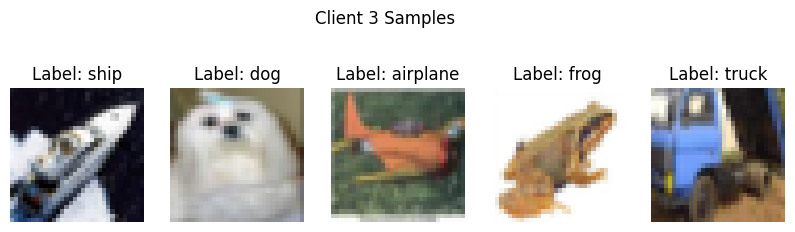

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.7142922514121979, Accuracy: 0.401
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7190858531776816, Accuracy: 0.3919
313/313 [==============================] - 1s 4ms/step
Client 3 - Loss: 1.7138926348913461, Accuracy: 0.4049
313/313 [==============================] - 1s 4ms/step
Client 4 - Loss: 1.7300511520352215, Accuracy: 0.398
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7213794047929347, Accuracy: 0.3996
Round 10/10
Client 1 providing information:


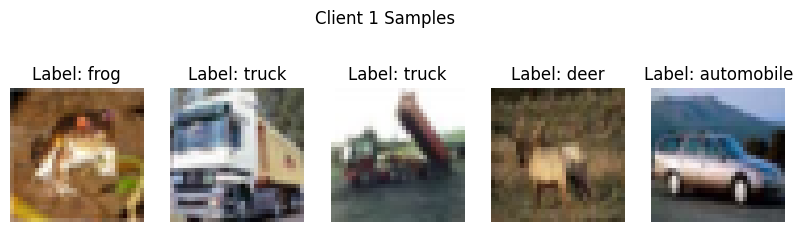

Client 3 providing information:


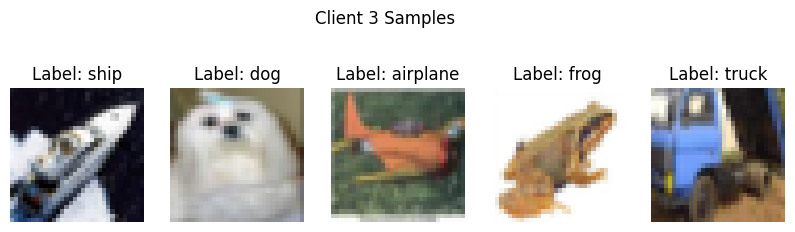

Client 5 providing information:


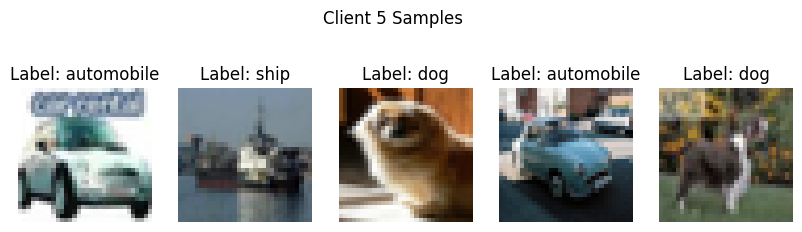

Client 4 providing information:


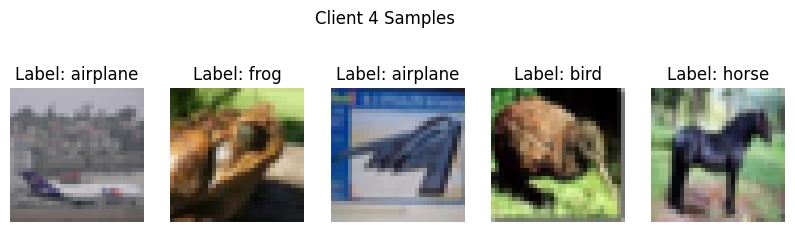

Client 2 providing information:


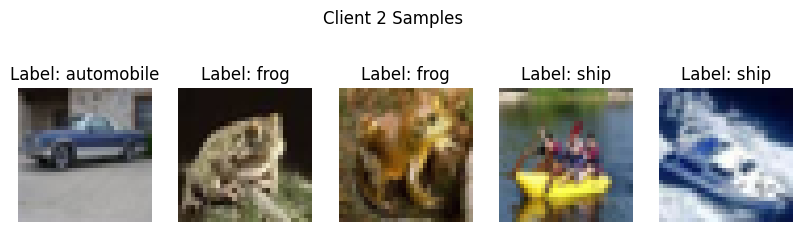

313/313 [==============================] - 1s 3ms/step
Client 1 - Loss: 1.7064812742363662, Accuracy: 0.3992
313/313 [==============================] - 1s 3ms/step
Client 2 - Loss: 1.7001453929394483, Accuracy: 0.4102
313/313 [==============================] - 1s 3ms/step
Client 3 - Loss: 1.7092507521208375, Accuracy: 0.3973
313/313 [==============================] - 1s 3ms/step
Client 4 - Loss: 1.7190455384135246, Accuracy: 0.4
313/313 [==============================] - 1s 3ms/step
Client 5 - Loss: 1.7005009470202028, Accuracy: 0.4069


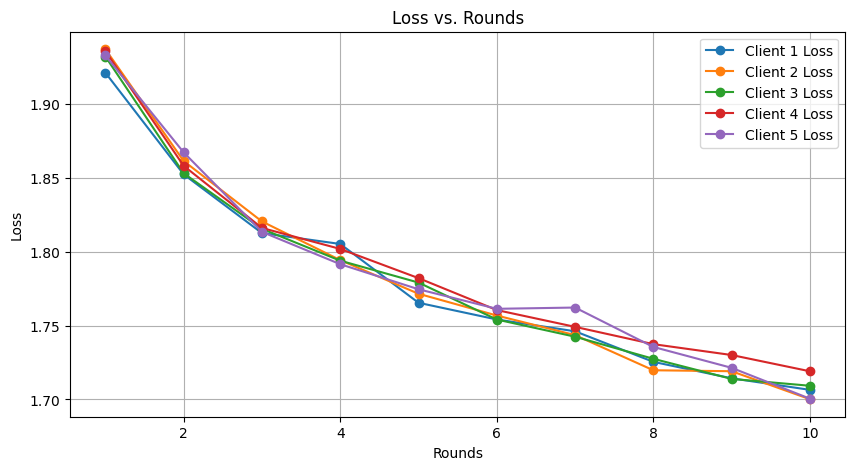

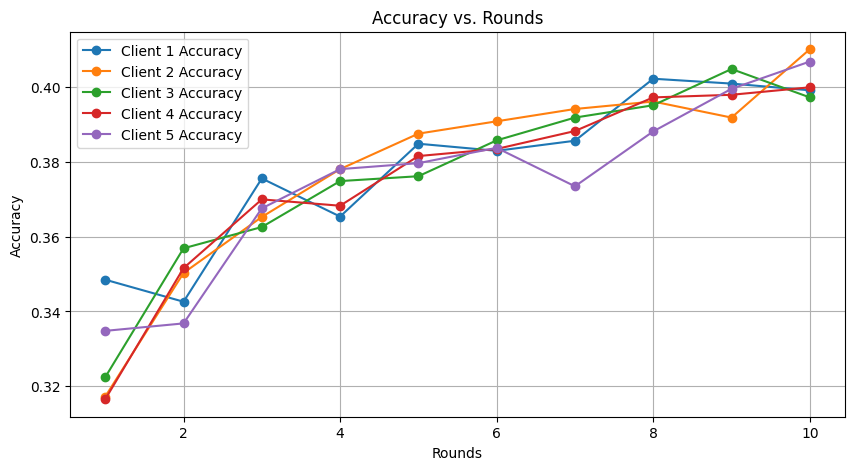

In [13]:
client_losses, client_accuracies = semi_async_update(client_models, server_model, client_data, client_labels, epochs, batch_size)

# Plot the results
plt.figure(figsize=(10, 5))

# Plot loss vs. rounds for each client
for i in range(len(client_losses)):
    plt.plot(range(1, rounds+1), client_losses[i], marker='o', label=f'Client {i + 1} Loss')

plt.title('Loss vs. Rounds')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))

# Plot accuracy vs. rounds for each client
for i in range(len(client_accuracies)):
    plt.plot(range(1, rounds+1), client_accuracies[i], marker='o', label=f'Client {i + 1} Accuracy')

plt.title('Accuracy vs. Rounds')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()